In [1]:
library(singleCellNet)
source("/fast/AG_Haghverdi/Carla_Moelbert/Benchmarking_TrainingDataSelection/Scripts/functions.R")
folder <- "../Data/subsets/Mono_100_1/"

data <- readData(paste(sep="/", folder, "data_train.txt"))
data <- data[rowSums(data)>=5,]
meta <- read.csv(paste(sep="/",folder, "meta_train.txt"))

test <- readData(paste(sep="/", "../Data/processed/PBMC_mono/", "data_test.txt"))
meta_test <- read.csv(paste(sep="/", "../Data/processed/PBMC_mono/", "meta_test.txt")) 


Loading required package: ggplot2

Loading required package: dplyr

Warning message:
“package ‘dplyr’ was built under R version 4.1.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: pheatmap

Loading required package: reshape2

Loading required package: cowplot


Attaching package: ‘docstring’


The following object is masked from ‘package:utils’:

    ?


Warning message in data.table::fread(data, sep = ",", verbose = F):
“Detected 842 column names but the data has 843 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in data.table::fread(data, sep = ",", verbose = F):
“Detected 6584

In [10]:
ncells <- as.numeric(stringr::str_split("Mono_100_1",pattern="_", simplify = T)[2])
ncells

[1] 100

In [16]:
commonGenes = intersect(rownames(data), rownames(test))

dataSub = data[commonGenes,]

In [12]:
set.seed(100) #can be any random seed number
stList = splitCommon(sampTab=meta, ncells=ncells, dLevel="class_")
stTrain = stList[[1]]

dataSub = data[,stTrain$id]

Cytotoxic T cell : 100 
CD14+ monocyte : 100 
CD16+ monocyte : 100 
B cell : 100 
CD4+ T cell : 100 
Megakaryocyte : 100 
Plasmacytoid dendritic cell : Category Plasmacytoid dendritic cell has 42 samples. Note this category has a samller number than ncells. 42 
Dendritic cell : 100 
Natural killer cell : 100 


In [23]:
table(meta$class_)
table(stTrain$class_)


                     B cell              CD14+ monocyte 
                        100                         100 
             CD16+ monocyte                 CD4+ T cell 
                        100                         100 
           Cytotoxic T cell              Dendritic cell 
                        100                         100 
              Megakaryocyte         Natural killer cell 
                        100                         100 
Plasmacytoid dendritic cell 
                         42 


                     B cell              CD14+ monocyte 
                         97                          97 
             CD16+ monocyte                 CD4+ T cell 
                         97                          97 
           Cytotoxic T cell              Dendritic cell 
                         97                          97 
              Megakaryocyte         Natural killer cell 
                         97                          97 
Plasmacytoid dendritic cell 
                         39 

In [18]:
class_info<-scn_train(stTrain =meta, expTrain = as.matrix(dataSub), nTopGenes = 10, nRand = 100, nTrees = 1000, 
                      nTopGenePairs = 25, dLevel = "class_", colName_samp = "id")



Sample table has been prepared
Expression data has been normalized
Finding classification genes
Done testing
There are  118  classification genes
Finding top pairs
nPairs =  190  for  Cytotoxic T cell 
nPairs =  190  for  CD14+ monocyte 
nPairs =  190  for  CD16+ monocyte 
nPairs =  190  for  B cell 
nPairs =  190  for  CD4+ T cell 
nPairs =  190  for  Megakaryocyte 
nPairs =  190  for  Plasmacytoid dendritic cell 
nPairs =  190  for  Dendritic cell 
nPairs =  190  for  Natural killer cell 
There are 223 top gene pairs
Finished pair transforming the data
Number of missing genes  0 
All Done


In [19]:
#validate data
#stTestList = splitCommon(sampTab=test, ncells=100, dLevel="class_") #normalize validation data so that the assessment is as fair as possible
#stTest = stTestList[[1]]
#expTest = data[commonGenes,stTest$id]

#predict
classRes_val_all = scn_predict(cnProc=class_info[['cnProc']], expDat=test, nrand = 50)

Loaded in the cnProc
All Done


Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collaps

[1] 0.3022309

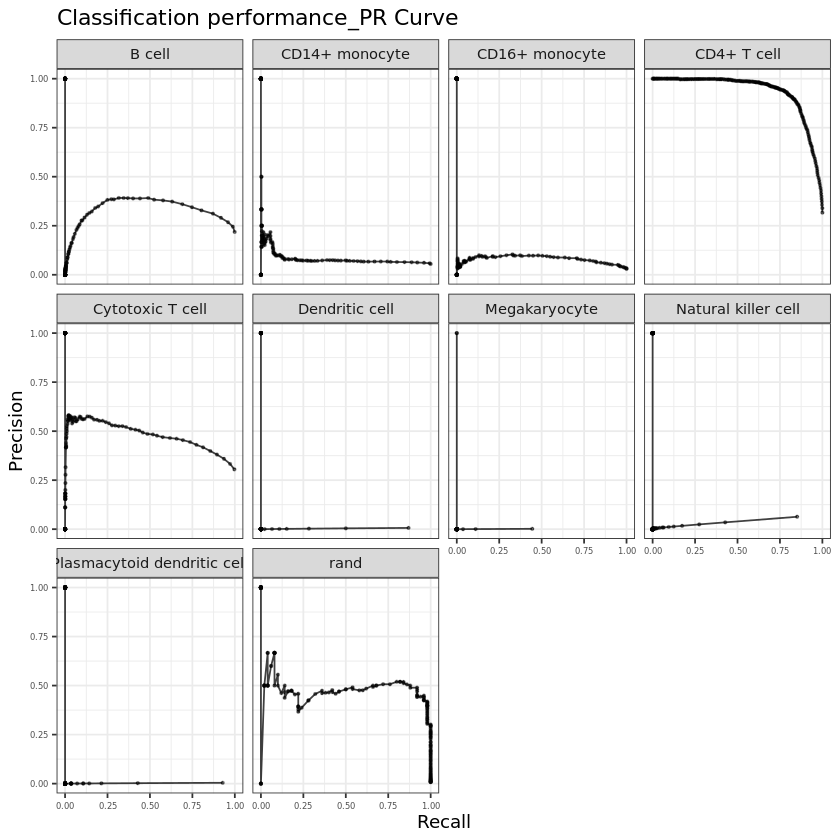

In [20]:
tm_heldoutassessment = assess_comm(ct_scores = classRes_val_all, stTrain = meta, stQuery = meta_test,
                                   dLevelSID = "id", classTrain = "class_", classQuery = "class_", nRand = 50)
tm_heldoutassessment$accuracy
plot_PRs(tm_heldoutassessment)

In [13]:
plot_metrics(tm_heldoutassessment)

ERROR: Error in p1 | p4: operations are possible only for numeric, logical or complex types


In [ ]:
print("-------------------")
nqRand = 50
predictions <-t(scn_predict(class_info[['cnProc']], test, nrand=nqRand))

predicted <- colnames(predictions)[apply(predictions,1,which.max)]
names(predicted)<- rownames(predictions)


x <- as.data.frame(predicted)

x$id <- rownames(x)

results <- merge(x, meta_test, by="id", all = T)

results$prediction.match <- results$predicted == results$class_
head(results)

write.table(results[,c("id","class_", "predicted", "prediction.match")], paste0(output,".txt") ,sep="\t", quote=F)